In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import sqlite3
import sys
from typing import Tuple
import os
import operator
import matplotlib.pyplot as plt

# Segur q es pot arreglar d'una altra forma
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import settings

# UTILS

## Dict

In [2]:
# Abreviatures extracted from https://laligafv.foroactivo.com/t5325-abreviaturas-de-los-equipos
team_names_3 = {
    "Alavés": "ALA",
    "Athletic": "ATH",
    "Atlético Madrid": "ATM",
    "Barcelona": "BAR",
    "CA Osasuna": "OSA",
    "Celta de Vigo": "CEL",
    "Cádiz CF": "CAD",
    "Elche CF": "ELC",
    "Getafe": "GET",
    "Granada CF": "GRA",
    "Levante": "LEV",
    "Real Betis": "BET",
    "Real Madrid": "RMA",
    "Real Sociedad": "RSO",
    "Real Valladolid": "VLL",
    "SD Eibar": "EIB",
    "SD Huesca": "HUE",
    "Sevilla FC": "SEV",
    "Valencia": "VAL",
    "Villarreal": "VIL",
}

## Functions

In [3]:
def filter_season(df: DataFrame, season: str) -> DataFrame:
    """
    Filters and returns the matches within a specified season.

    :param df: DataFrame containing match data.
    :param season: Season where values will be extracted

    :return: DataFrame containing the matches within the specified season.
    """

    return df.loc[df["season"] == season]


def extract_season_values(
    df: DataFrame, season: str, column: str
) -> Tuple[DataFrame, DataFrame]:
    """
    Extracts and returns the counts of matches per weekday and per time within a specified season.

    :param df: DataFrame containing match data.
    :param season: Season where values will be extracted
    :param column: The column name to be used for extracting time values.

    :return: A tuple containing two DataFrames:
        - df_weekday: DataFrame with counts of matches per weekday.
        - df_time: DataFrame with counts of matches per time.
    """
    df_season = filter_season(df, season)

    df_weekday = df_season["date"].dt.day_name().value_counts().reset_index()
    df_weekday.columns = ["weekday", "count"]

    df_time = df_season[column].value_counts().reset_index()
    df_time.columns = ["time", "count"]
    return df_weekday, df_time

In [4]:
def won_games(df, team: str):
    """
    Returns those winning games for a given team
    """
    home_wins = (df["home_team"] == team) & (df["home_win"] == 1)
    away_wins = (df["away_team"] == team) & (df["away_win"] == 1)
    return df[home_wins | away_wins]


def lost_games(df, team: str):
    """
    Returns those winning games for a given team
    """
    home_lost = (df["home_team"] == team) & (df["home_win"] == 0)
    away_lost = (df["away_team"] == team) & (df["away_win"] == 0)

    return df[home_lost | away_lost]


def count_team_wins(df: DataFrame, team: str) -> int:
    """
    Count the number of wins for a specified team in a given DataFrame.
    """
    return won_games(df, team).shape[0]


def count_team_lost(df: DataFrame, team: str) -> int:
    """
    Count the number of lost for a specified team in a given DataFrame.
    """

    return lost_games(df, team).shape[0]


def count_team_goals(df: DataFrame, team: str) -> int:
    """
    Count the total number of goals scored by a specific team.

    :param df: The DataFrame containing match data.
    :type df: pd.DataFrame
    :param team: The name of the team for which to count the goals.
    :type team: str
    :return: The total number of goals scored by the team.
    :rtype: int
    """
    home_goals = df[df["home_team"] == team]
    away_goals = df[df["away_team"] == team]
    return home_goals["home_score"].sum() + away_goals["away_score"].sum()

# LOAD DATA

In [5]:
with sqlite3.connect(settings.DATABASE_PATH) as conn:
    df = pd.read_sql(
        f"""
            SELECT * FROM Matches
        """,
        conn,
    )

## Pretreatment

Date is provided as mm/dd/YY as there two centuries (1900/2000) the format mm/dd/YYYY will be used to more clear.

In [6]:
def adjust_date(row):
    """
    Adjust the date by adding the correct century based on the season.
    If the date's year is less than the season's end year, use the start year,
    otherwise use the end year of the season.

    :param row: A row from the DataFrame containing 'date' and 'season'.
    :return: Adjusted date string in the format DD/MM/YYYY.
    """
    start_year = int(row["season"].split("-")[0])
    end_year = int(row["season"].split("-")[1])
    date_year = int(row["date"].split("/")[-1])

    if date_year == start_year % 100:
        return row["date"][:-2] + str(start_year)
    else:
        return row["date"][:-2] + str(end_year)


df["date"] = df.apply(adjust_date, axis=1)
df = df.dropna(subset=["date"])
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y")

Pendent de veure amb que omplim els valors nuls

In [7]:
df = df.dropna(subset=["score"])

Creation of util columns that will be used commonly. 

In [8]:
df["home_score"] = df["score"].str.split(":").str[0].astype(int)
df["away_score"] = df["score"].str.split(":").str[1].astype(int)

In [9]:
df["home_win"] = (df["home_score"] > df["away_score"]).astype(int)
df["away_win"] = (df["home_score"] < df["away_score"]).astype(int)
df["tie"] = (df["home_score"] == df["away_score"]).astype(int)

## EX 1

In [10]:
home_wins = df["home_win"].sum()
away_wins = df["away_win"].sum()
ties = df["tie"].sum()

Text(0.5, 1.0, 'Match results')

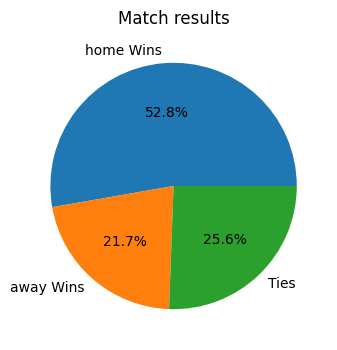

In [11]:
labels = ["home Wins", "away Wins", "Ties"]
sizes = [home_wins, away_wins, ties]

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct="%1.1f%%")

plt.title("Match results")

# Ex2

In [12]:
df_1 = df.loc[df["division"] == 1].copy()

In [13]:
scored_goals = (
    df_1.groupby("home_team")["home_score"].sum()
    + df_1.groupby("away_team")["away_score"].sum()
).sort_values(ascending=False)

top_10_scored = scored_goals[:10]

print(top_10_scored)

home_team
Barcelona          6267
Real Madrid        6249
Athletic           4802
Valencia           4615
Atlético Madrid    4184
Sevilla FC         3903
Espanyol           3720
Real Sociedad      3200
Real Zaragoza      2683
Celta de Vigo      2483
dtype: int32


In [14]:
conceded_goals = (
    df_1.groupby("home_team")["away_score"].sum()
    + df_1.groupby("away_team")["home_score"].sum()
).sort_values(ascending=False)

top_10_conceded = conceded_goals[:10]

print(top_10_conceded)

home_team
Espanyol           4034
Athletic           3875
Valencia           3649
Sevilla FC         3546
Real Madrid        3287
Barcelona          3259
Real Sociedad      3126
Atlético Madrid    2894
Celta de Vigo      2856
Real Zaragoza      2847
dtype: int32


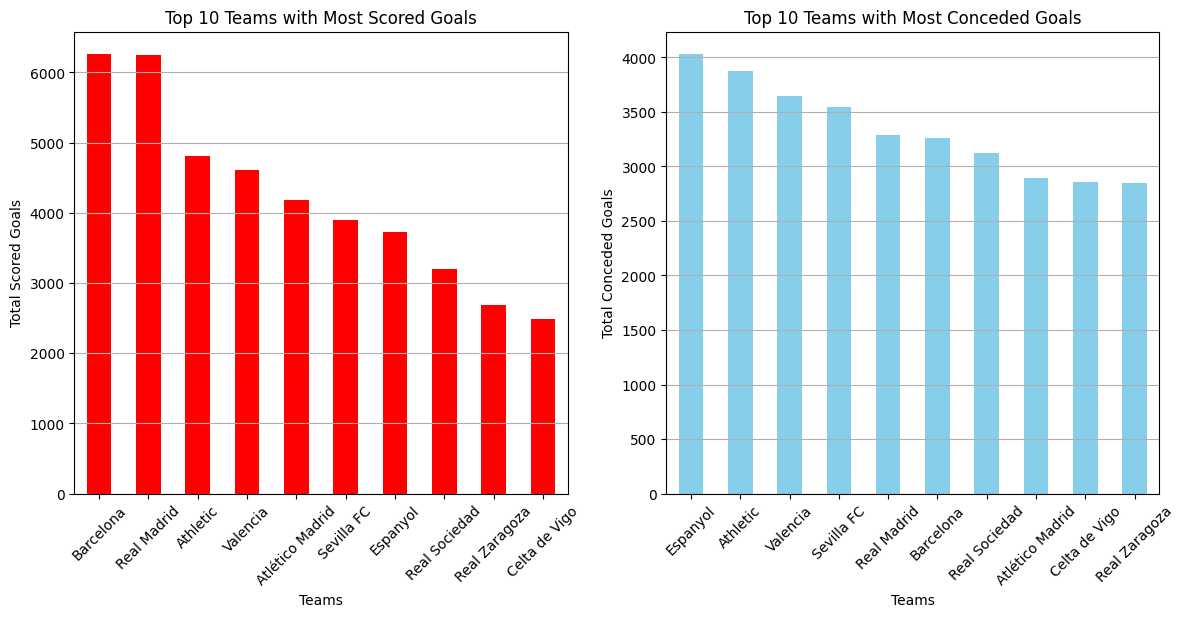

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

top_10_scored.plot(kind="bar", color="red", ax=axs[0])
axs[0].set_title("Top 10 Teams with Most Scored Goals")
axs[0].set_xlabel("Teams")
axs[0].set_ylabel("Total Scored Goals")
axs[0].set_xticklabels(top_10_scored.index, rotation=45)
axs[0].grid(axis="y")

top_10_conceded.plot(kind="bar", color="skyblue", ax=axs[1])
axs[1].set_title("Top 10 Teams with Most Conceded Goals")
axs[1].set_xlabel("Teams")
axs[1].set_ylabel("Total Conceded Goals")
axs[1].set_xticklabels(top_10_conceded.index, rotation=45)
axs[1].grid(axis="y")

In [16]:
df_1["difference_score"] = df_1["home_score"] - df_1["away_score"]
df_1["abs_difference_score"] = df_1["difference_score"].abs()
df_1.sort_values("abs_difference_score", ascending=False).head(10)[
    ["home_team", "away_team", "score"]
]

,home_team,away_team,score
225,Athletic,Barcelona,12:1
936,Sevilla FC,Barcelona,11:1
2787,Athletic,Lérida,10:0
1168,Athletic,Celta de Vigo,10:0
1071,Sevilla FC,Real Oviedo,10:0
3629,Barcelona,Real Oviedo,9:0
10024,Barcelona,Rayo Vallecano,9:0
408,Racing,Alavés,9:0
5027,Real Madrid,Elche CF,11:2
3911,Atlético Madrid,Hércules CF,9:0


# EX3

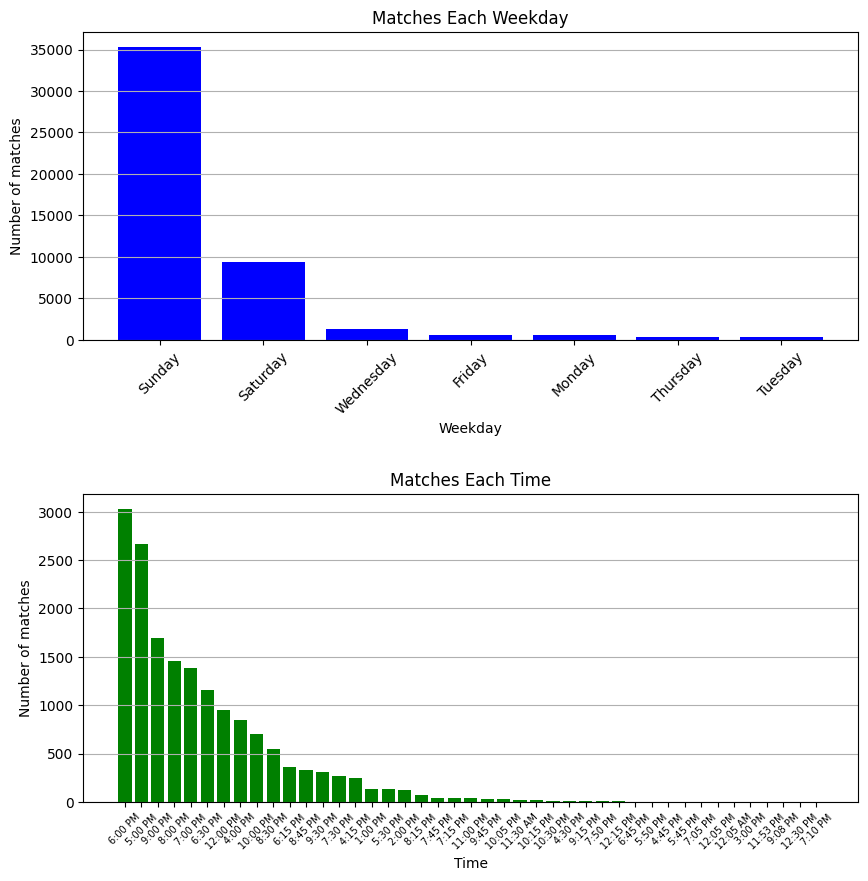

In [17]:
df_weekday = df["date"].dt.day_name().value_counts()
df_time = df["time"].value_counts()

df_weekday = df_weekday.reset_index()
df_weekday.columns = ["weekday", "count"]

df_time = df_time.reset_index()
df_time.columns = ["time", "count"]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].bar(df_weekday["weekday"], df_weekday["count"], color="blue")
axes[0].set_title("Matches Each Weekday")
axes[0].set_xlabel("Weekday")
axes[0].set_ylabel("Number of matches")
axes[0].set_xticks(range(len(df_weekday["weekday"])))
axes[0].set_xticklabels(df_weekday["weekday"], rotation=45)
axes[0].grid(axis="y")

axes[1].bar(df_time["time"], df_time["count"], color="green")
axes[1].set_title("Matches Each Time")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Number of matches")
axes[1].set_xticks(range(len(df_time["time"])))
axes[1].set_xticklabels(df_time["time"], rotation=45, fontsize=7)
axes[1].grid(axis="y")

plt.subplots_adjust(hspace=0.5)

plt.show()

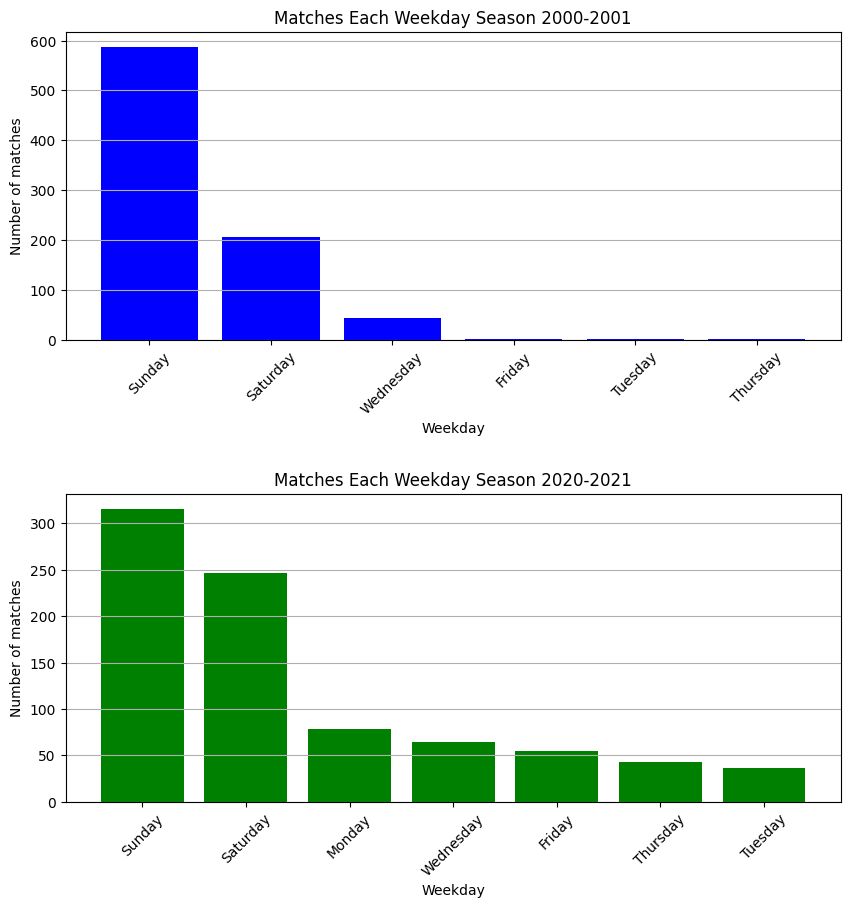

In [18]:
df_weekday_2000, df_time_2000 = extract_season_values(df, "2000-2001", "date")
df_weekday_2020, df_time_2020 = extract_season_values(df, "2020-2021", "date")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].bar(df_weekday_2000["weekday"], df_weekday_2000["count"], color="blue")
axes[0].set_title("Matches Each Weekday Season 2000-2001")
axes[0].set_xlabel("Weekday")
axes[0].set_ylabel("Number of matches")
axes[0].set_xticks(range(len(df_weekday_2000["weekday"])))
axes[0].set_xticklabels(df_weekday_2000["weekday"], rotation=45)
axes[0].grid(axis="y")

axes[1].bar(df_weekday_2020["weekday"], df_weekday_2020["count"], color="green")
axes[1].set_title("Matches Each Weekday Season 2020-2021")
axes[1].set_xlabel("Weekday")
axes[1].set_ylabel("Number of matches")
axes[1].set_xticks(range(len(df_weekday_2020["weekday"])))
axes[1].set_xticklabels(df_weekday_2020["weekday"], rotation=45)
axes[1].grid(axis="y")

plt.subplots_adjust(hspace=0.5)

plt.show()

# EX4

In [19]:
def highlight_wins(val):
    if isinstance(val, str):
        val = int(val.split(":")[0]) - int(val.split(":")[1])
    if val > 0:
        intensity = min(val / 10, 1)
        return f"background-color: rgba(0, 255, 0, {intensity})"
    elif val < 0:
        intensity = min(-val / 10, 1)
        return f"background-color: rgba(255, 0, 0, {intensity})"
    elif val == 0:
        intensity = 0.5
        return f"background-color: rgba(255, 255, 0, {intensity})"
    elif val == "":
        return f"background-color: rgba(255, 255, 255, 1)"
    return ""

In [20]:
df_2020 = filter_season(df_1, "2020-2021")

cross_table = pd.crosstab(
    df_2020["home_team"], df_2020["away_team"], values=df_2020["score"], aggfunc="sum"
)

cross_table = cross_table.rename(columns=team_names_3)

cross_table.index.name = None
cross_table.columns.name = "Home & Away"

cross_table = cross_table.style.applymap(highlight_wins)

cross_table

Home & Away,ALA,ATH,ATM,BAR,OSA,CEL,CAD,ELC,GET,GRA,LEV,BET,RMA,RSO,VLL,EIB,HUE,SEV,VAL,VIL
Alavés,nan,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,nan,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,nan,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,nan,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,nan,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,nan,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,nan,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,nan,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,nan,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3
Granada CF,2:1,2:0,1:2,0:4,2:0,0:0,0:1,2:1,0:0,nan,1:1,2:0,1:4,1:0,1:3,4:1,3:3,1:0,2:1,0:3


In [21]:
# queda fer la funcio

# EX5

In [22]:
def team_confrontations(df, team1, team2):
    df_confrontations = df.loc[
        ((df["home_team"] == team1) | (df["away_team"] == team1))
        & ((df["home_team"] == team2) | (df["away_team"] == team2))
    ]

    return df_confrontations

In [23]:
df_bm = team_confrontations(df, "Barcelona", "Real Madrid")
bcn_wins = count_team_wins(df_bm, "Barcelona")
mad_wins = count_team_wins(df_bm, "Real Madrid")
ties = df_bm["tie"].sum()
print(
    f"Barcelona has won {bcn_wins} games, while Real Madrid has won {mad_wins} games. There has been {ties} ties."
)

Barcelona has won 72 games, while Real Madrid has won 75 games. There has been 35 ties.


In [24]:
bcn_goals = count_team_goals(df_bm, "Barcelona")
mad_goals = count_team_goals(df_bm, "Real Madrid")

print(
    f"Barcelona has scored {bcn_goals} goals, while Real Madrid has scored {mad_goals} goals"
)

Barcelona has scored 290 goals, while Real Madrid has scored 293 goals


In [25]:
def plot_direct_confrontations_stats(df: DataFrame, team1: str, team2: str):
    """
    Plot the statistics of direct confrontations between two teams.

    :param df: The DataFrame containing match data.
    :type df: pd.DataFrame
    :param team1: The name of the first team.
    :type team1: str
    :param team2: The name of the second team.
    :type team2: str
    """
    if team1 not in team_names_3:
        raise ValueError(f"Team {team1} not found in the team names dictionary.")
    if team2 not in team_names_3:
        raise ValueError(f"Team {team2} not found in the team names dictionary.")

    df_confrontations = team_confrontations(df, team1, team2)
    team1_wins = count_team_wins(df_confrontations, team1)
    team2_wins = count_team_wins(df_confrontations, team2)
    ties = df_confrontations["tie"].sum()

    labels = [f"{team1} Wins", f"{team2} Wins", "Ties"]
    sizes = [team1_wins, team2_wins, ties]

    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, autopct="%1.1f%%")

    plt.title("Match results")
    plt.show()

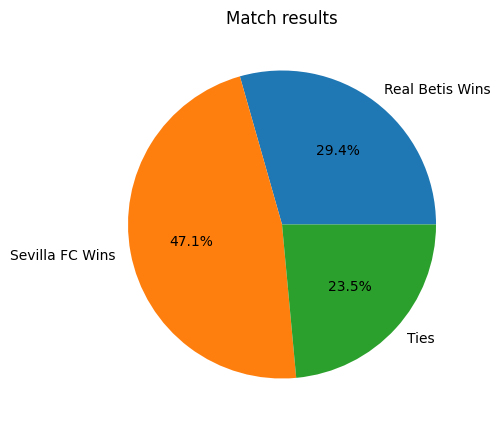

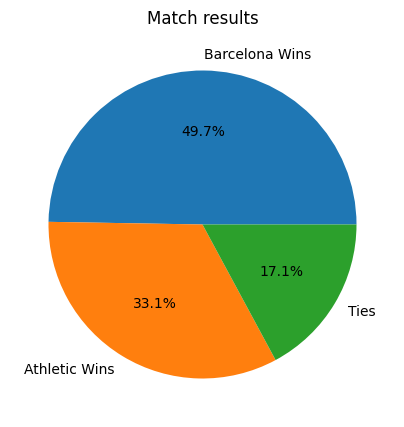

In [26]:
plot_direct_confrontations_stats(df, "Real Betis", "Sevilla FC")
plot_direct_confrontations_stats(df, "Barcelona", "Athletic")

# EX6

In [27]:
# LOGICA MOLT MILLORALBE


def replace_strikes_with_max(data):
    """
    Replace each sequence of consecutive increasing non-zero numbers in the array
    with the maximum value of that sequence.
    """
    arr = np.array(data)

    non_zero_mask = arr != 0

    streak_starts = np.diff(np.concatenate(([0], non_zero_mask.astype(int))))
    start_indices = np.where(streak_starts == 1)[0]

    end_indices = np.where(streak_starts == -1)[0]
    if non_zero_mask[-1]:
        end_indices = np.append(end_indices, len(arr))

    for start, end in zip(start_indices, end_indices):
        arr[start:end] = np.max(arr[start:end])

    return set(arr)


def calculate_non_lose_strike(df, team):
    """
    Calculate the non-lose streak for a given team, and replace each strike with its maximum value.
    """
    df_team = select_team(df, team)

    is_non_lose = df_team["is_non_lose"].astype(int)
    streak_group = (is_non_lose != is_non_lose.shift()).cumsum()
    non_lose_streak = is_non_lose.groupby(streak_group).cumsum().values

    return replace_strikes_with_max(non_lose_streak)

In [28]:
unique_teams = sorted(df["home_team"].unique())
non_lose_strike_data = [
    (team, strike)
    for team in unique_teams
    for strike in calculate_non_lose_strike(df, team)
]

non_lose_strike_df = pd.DataFrame(
    non_lose_strike_data, columns=["team", "strike"]
).sort_values(by="strike", ascending=False)
print("Top 10 teams with biggest non-lose strikes ever are", non_lose_strike_df)

NameError: name 'select_team' is not defined

In [ ]:
top_50_non_lose_strike_df = non_lose_strike_df.head(50)

plt.figure(figsize=(12, 8))
plt.barh(
    top_50_non_lose_strike_df["team"],
    top_50_non_lose_strike_df["strike"],
    color="skyblue",
)
plt.xlabel("Non-Lose Strike")
plt.ylabel("Team")
plt.title("Top 50 Teams with Biggest Non-Lose Strikes")
plt.gca().invert_yaxis()
plt.show()

# FALTA ACABAR, MARCANT LES DATES DE LES RATXES.

## EX 7

In [30]:
def calculate_team_results(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a DataFrame from a historic table of results to a final standings of each season and division.
    It is ordered by points per season. In case two teams have same number of points, is ordered by GD (de-
    scending), and then by GF (also descending).

    :param df: DataFrame containing match data for all teams.
    :return: DataFrame with results for each team and season.
    """

    df_results = (
        pd.concat(
            [
                df.groupby(["division", "season", "home_team"])
                .agg(
                    GF=("home_score", "sum"),
                    GA=("away_score", "sum"),
                    W=("home_win", "sum"),
                    L=("away_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"home_team": "team"}),
                df.groupby(["division", "season", "away_team"])
                .agg(
                    GF=("away_score", "sum"),
                    GA=("home_score", "sum"),
                    W=("away_win", "sum"),
                    L=("home_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"away_team": "team"}),
            ]
        )
        .groupby(["division", "season", "team"])
        .sum()
        .reset_index()
    )

    df_results["GD"] = df_results["GF"] - df_results["GA"]
    df_results["points"] = df_results["W"] * 3 + df_results["T"]

    df_results = df_results.sort_values(
        by=["division", "season", "points", "GD", "GF"],
        ascending=[True, False, False, False, False],
    ).reset_index(drop=True)

    df_results["rank"] = (
        df_results.groupby(["season", "division"])["points"]
        .rank("first", ascending=False)
        .astype(int)
    )

    df_results = df_results[
        [
            "season",
            "division",
            "rank",
            "team",
            "GF",
            "GA",
            "GD",
            "W",
            "L",
            "T",
            "points",
        ]
    ]
    return df_results


df_results = calculate_team_results(df)
# df_results.to_excel("../reports/SeasonStandings.xlsx", index=False) Descomentar si es vol generar

